In [3]:
import imblearn
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import itertools
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

              precision    recall  f1-score   support

     anomaly       0.99      1.00      0.99      3498
      normal       1.00      0.99      1.00      4060

    accuracy                           0.99      7558
   macro avg       0.99      0.99      0.99      7558
weighted avg       0.99      0.99      0.99      7558



0.9947075946017465

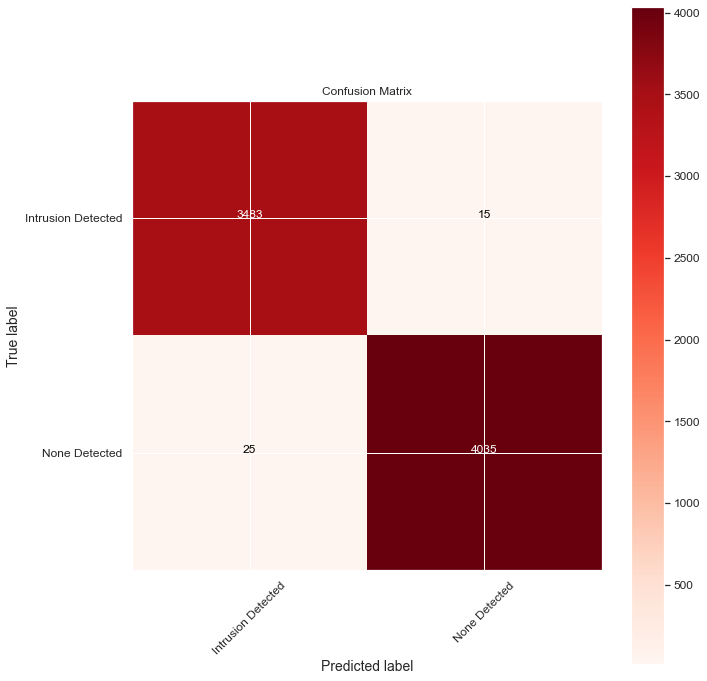

In [2]:
#==========our plot and panda settings because the dataset is large===================#
pd.set_option('display.max_columns', None)
sns.set(style="darkgrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

#===================Loading and understanding the dataset better=============================#
train = pd.read_csv(r'C:\Users\hp\Desktop\Train_data.csv')
test = pd.read_csv(r'C:\Users\hp\Desktop\Test_data.csv')

#print(test.head(5))
#print(train.head(5))
#train.describe()
#test.describe()
#print("Training data has {} rows & {} columns".format(train.shape[0],train.shape[1]))
#print("Test data has {} rows & {} columns".format(test.shape[0],test.shape[1]))
#print(train['num_outbound_cmds'].value_counts())
#print(test['num_outbound_cmds'].value_counts())
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)
#print(train)
#print(test)

#=====scaling the numerical attribute, scaling is used to bring data points far from each other closer#
#To do this i'm extracting the numerical attributes and making the mean and variance 0#
scaler = StandardScaler()
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))
# Returning it to the data frame
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

encoder = LabelEncoder()

# extract categorical attributes from both training and test sets 
cattrain = train.select_dtypes(include=['object']).copy()
cattest = test.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data 
enctrain = traincat.drop(['class'], axis=1)
cat_Ytrain = traincat[['class']].copy()

train_x = pd.concat([sc_traindf,enctrain],axis=1)
train_y = train['class']
#print(train_y.shape)

test_df = pd.concat([sc_testdf,testcat],axis=1)
#print(test_df.shape)

#===========For our feature selection, we'll be using a package known as ensemble===========#
# we'll be using a Random forest classifier for it

# fit random forest classifier on the training set
rfc = RandomForestClassifier()
rfc.fit(train_x, train_y);
# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
#importances.plot.bar();
# The graph i just plotted ranks the most important features of the dataset by getting the scores of each
   # feature and ranking them in a descending order(from highest to lowest)
    #from the graph you can see that source_bytes is the most important feature of the dataset
    
# now we have to use the RFE(Recursive feature elimination) model to fit a model and remove the weakest
  #features cos they will have little or no effect on the model
    
# create the RFE model and select 15 attributes
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(train_x, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

#selected_features

# Basically the above block of code tells the RFE model to pick just the 15 most important features
#These are the features we will use to train our model

# now let me split my data into training and testing and also fit in my models

X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,train_size=0.70, random_state=2)

# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, Y_train)
y_pred1 = DTC_Classifier.predict(X_test)
cm1 = confusion_matrix(Y_test, y_pred1)
print(classification_report(Y_test, y_pred1))

# Now i want to evaluate the model with popular performance metrics
def plot_confusion_matrix1(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
target_names = ["Intrusion Detected", "None Detected"]
plot_confusion_matrix1(cm1, target_names, normalize=False, title='Confusion Matrix')
accuracy_score(Y_test, y_pred1)

    

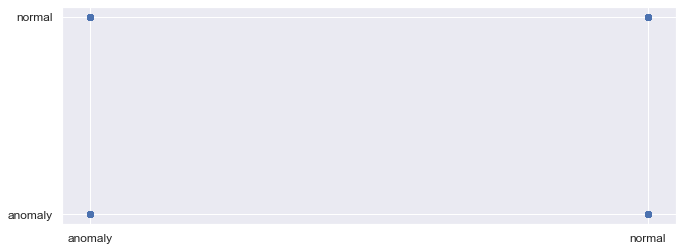

In [8]:
plt.scatter(Y_test, y_pred1)
plt.show()

              precision    recall  f1-score   support

     anomaly       0.99      0.94      0.96      3498
      normal       0.95      0.99      0.97      4060

    accuracy                           0.96      7558
   macro avg       0.97      0.96      0.96      7558
weighted avg       0.97      0.96      0.96      7558



0.9642762635617889

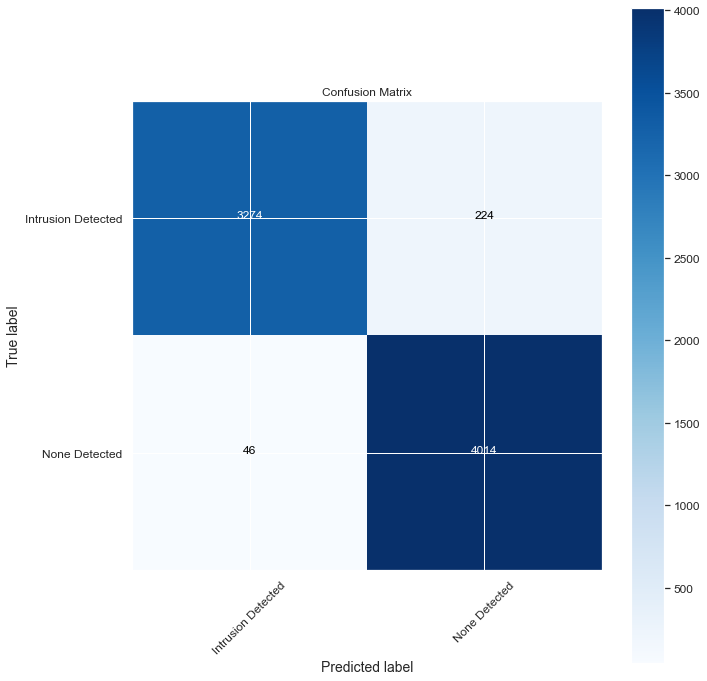

In [9]:
#Train SVM model
SVM_Classifier = SVC(random_state=0)
SVM_Classifier.fit(X_train, Y_train)
y_pred2 = SVM_Classifier.predict(X_test)
cm2 = confusion_matrix(Y_test, y_pred2)
print(classification_report(Y_test, y_pred2))

def plot_confusion_matrix1(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
target_names = ["Intrusion Detected", "None Detected"]
plot_confusion_matrix1(cm2, target_names, normalize=False, title='Confusion Matrix')
accuracy_score(Y_test, y_pred2)


<function matplotlib.pyplot.show(close=None, block=None)>

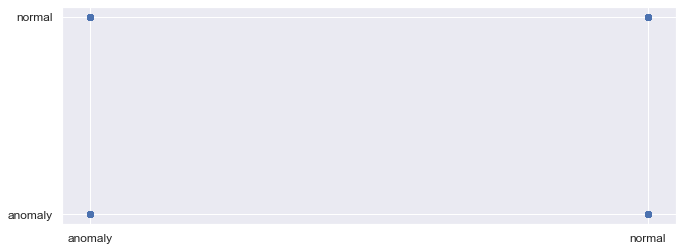

In [15]:
plt.scatter(Y_test, y_pred2)
plt.show